# **Анализ результатов A/B-тестирования: статистические тесты**

В прошлом модуле мы рассматривали различные статистические тесты и их использование в Python. Суть статистических тестов заключается в том, чтобы **удостовериться в справедливости некоторой гипотезы или опровергнуть её** на основе предоставленных данных (выборки).

Наша задача состоит в проверке гипотезы о различиях (равенстве) между истинными конверсиями в группах, исходя из выборочных конверсий. Мы хотим ответить на вопрос: «А существует ли статистическая значимость в эффективности (по конверсии) контрольного и тестового варианта?»

In [47]:
# Импортируем функцию proportions_ztest() из модуля statsmodels:
from statsmodels.stats.proportion import proportions_ztest

# импортируем библиотеки, которые нам пригодятся:
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

In [4]:
ab_data = pd.read_csv('data/ab_data.csv')
display(ab_data.head())

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


***
### **СТАТИСТИЧЕСКИЙ ТЕСТ ДЛЯ КОНВЕРСИИ**
Оказывается, интересующий нас признак того, осуществлена конверсия пользователя или нет, — это случайная величина, имеющая распределение [**Бернулли**](https://ru.wikipedia.org/wiki/Распределение_Бернулли). Такая случайная величина имеет два возможных исхода: 

* успех (1) — пользователь осуществил конверсию (совершил целевое действие); 
* неуспех (0) — пользователь не осуществил конверсию. 

Для проверки гипотезы равенства пропорций мы можем воспользоваться уже знакомым нам **z-критерием** для пропорций. Этот критерий является наиболее популярным для задачи определения статистической значимости изменения конверсии.

Примечание. Здесь и далее, когда мы говорим о равенстве, мы не имеем в виду фактическое равенство показателей (2=2). Мы хотим узнать, есть ли статистическое различие между полученными значениями. Но для простоты изъяснения обычно говорят просто о равенстве или неравенстве.

**[Например, мы можем иметь конверсию в 4 % для одной группы и в 4.5 % для другой. Фактически показатели не равны. Но это не говорит о том, что конверсия для другой группы лучше — возможно, подобное отклонение в пределах допустимого для рассматриваемых данных, и тогда речь о статистическом различии идти не может.]**

Нулевая гипотеза нашего теста всегда будет звучать следующим образом:

                            H0: pa = pb  то есть истинные пропорции в группах равны.
                            А вот альтернативных может быть несколько:
                            H1 (двусторонняя): pa <> pb, то есть истинные пропорции в группах не равны.
                            H1 (левосторонняя): pa < pb, то есть истинная пропорция группы А меньше, чем в группе B.
                            H1 (правосторонняя): pa > pb, то есть истинная пропорция группы А больше, чем в группе B.

✏️ Применим z-тест для пропорций на примере конверсии нашего интернет-магазина. 

Импортируем функцию **proportions_ztest()** из модуля **statsmodels**:

                            from statsmodels.stats.proportion import proportions_ztest

Напомним, что для получения z-статистики и p-value нам необходимо передать в функцию следующие аргументы:

* **count** — количество «успехов» (в каждой из групп). В нашем случае — количество пользователей, которые совершили целевое действие в каждой группе.
* **nobs** — количество наблюдений (в каждой из групп), то есть размер выборки.
* **alternative** — альтернативная гипотеза. Может быть: 'two-sided' — двусторонняя, 'smaller' — левосторонняя, 'larger' — правосторонняя. По умолчанию параметр равен 'two-sided'. 

✏️ Итак, сгруппируем данные по признаку группы и рассчитаем количество «успехов» (сумма по столбцу converted) и общее количество наблюдений (количество непустых значений в столбце converted) для каждой группы.

In [5]:
converted_piv= ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,17467,145241
B,17238,145241


Теперь у нас с вами есть всё для того, чтобы проверить гипотезу о равенстве конверсий. 

Итак, будем проверять следующую новую гипотезу:

* H0: pa = pb, то есть конверсии в группах А и B равны.

При правосторонней альтернативной гипотезе (ранее из кумулятивных графиков мы видели, что кумулятивная конверсия в группе А выше, чем в группе B, поэтому мы хотим удостовериться в этом с помощью статистического теста, и нам подойдёт правосторонняя гипотеза):

* H0: pa > pb, то есть конверсия в группе А выше, чем конверсия в группе B.

Зададим уровень значимости **a = 0.05** и будем сравнивать полученное **p-value** с ним. По умолчанию функция **proportions_ztest()** возвращает z-статистику и p-value для двусторонней альтернативной гипотезы (конверсии в группах не равны). 

✏️ Z-статистика нас пока что не интересует, а вот p-value занесём в отдельную переменную для дальнейшего сравнения с уровнем значимости.

In [8]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу, что {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.1
Отвергаем нулевую гипотезу, что Конверсии в группах А и B равны
Альтернативная гипотеза. H1: Конверсия в группе А выше, чем конверсия в группе B


**Что это значит для нас и для бизнеса?** Так как z-тест для пропорций показал, что истинные значения конверсий в группах равны (с уровнем значимости 0.05), то полученная разница в метрике в группах статистически не значима. Переводим на язык бизнеса: разницы между вариантами рекомендаций сопутствующих товаров нет — они одинаково эффективны по метрике конверсии! 

На основе этого вывода мы принимаем решение о том, что делать дальше. Возможные варианты:

* отказаться от внедрения ML-модели для рекомендаций сопутствующих товаров и оставить использование текущей версии рекомендаций;
* попытаться усовершенствовать модель и провести тестирование снова;
* использовать оба варианта системы рекомендаций и посмотреть на результат в более долгосрочной перспективе.

Примечание. Важно отметить, что тест для пропорций можно применять **не только к конверсии**. Например, так же можно оценивать долю больных людей, долю просроченных кредитов и так далее.

✏️ Заметим, что, если повысить уровень значимости до a = 0.1, то есть «ослабить» требование по точности, можно получить уровень конверсии в группе А, всё-таки превышающий конверсию в группе B.

**Какой уровень значимости выбрать?**

Стараются придерживаться уровней значимости а = 0.05 или а = 0.1. Помним, что больший уровень значимости подразумевает больший риск совершить ошибку I рода (отклонить верную нулевую гипотезу).  
Вы сами определяете уровень значимости в зависимости от вашей гипотезы и того, сколько будет стоить вам ошибка I рода.
Как правило, если возникают спорные ситуации, то склоняются в пользу уже существующего варианта А, так как он не требует временных и денежных затрат на внедрение.  
В нашем примере варианты А и B оказались равными по признаку конверсии при уровне значимости а = 0.05, однако при уровне значимости а = 0.1 вариант А оказывается более эффективным.  
Так или иначе, немедленное внедрение варианта B — определённо не лучшая идея. Либо его необходимо доработать и провести тестирование заново, либо стоит отказаться от него вовсе.  

***
### **СТАТИСТИЧЕСКИЕ ТЕСТЫ ДЛЯ ДРУГИХ МЕТРИК**

На самом деле наша с вами задача об оценке эффективности двух вариантов была очень упрощена. Мы с вами рассматривали только одну метрику — конверсию добавления в корзину. Но на деле обычно смотрят на несколько показателей в комплексе!

Помимо конверсии, нужно рассматривать и другие метрики, например средний чек. Возможно же такое, что конверсия в группах одинаковая, а вот средние чеки существенно различаются! 

В таком случае проводятся статистические тесты для обеих метрик, и решение принимается в пользу варианта, который эффективнее по более приоритетной метрике (например, если мы хотим повысить прибыль, это будет средний чек).
***
Давайте рассмотрим следующий пример.

**[Мы проводим A/B-тест, чтобы оценить, влияет ли тема оформления на привлекательность сайта для пользователя. Гипотеза заключается в том, что тёмная тема более привлекательная для наших посетителей, поэтому их сильнее заинтересует наш сайт, следовательно, они проведут на нём больше времени. Уровень значимости равен 5 %.]**

Результаты тестирования представлены в [**XLSX-файле**](https://lms.skillfactory.ru/assets/courseware/v1/fa6ff6fcf8330b73c486bd328d47b632/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/time_data.zip).

In [9]:
time_data = pd.read_excel('data/time_data.xlsx')
display(time_data.head())

,time(A),time(B)
0,435.0,549.2
1,454.5,630.2
2,447.0,437.2
3,480.0,637.2
4,561.0,712.4


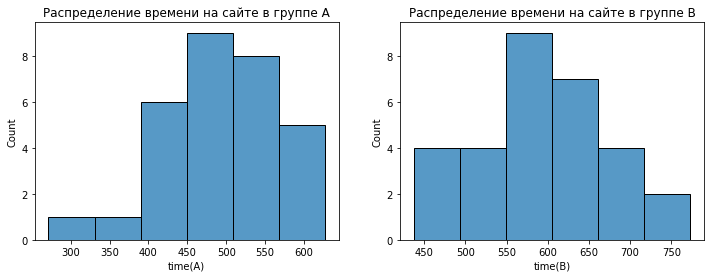

In [12]:
# Построим гистограмму времени, проведённом пользователями на сайте в каждой из групп:
#создаём 2 графика размером 12x4
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='time(A)', data=time_data, ax=axes[0])
sns.histplot(x='time(B)', data=time_data, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

Гистограммы **напоминают нормальное распределение**. Давайте проверим гипотезу о нормальности обоих распределений с помощью критерия **Шапиро-Уилка**. Для этого используем функцию **shapiro()** из модуля **scipy.stats**:

In [14]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(time_data['time(A)'])
shapiro_result_b = shapiro(time_data['time(B)'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.43
p-value группы B 0.12
Принимаем нулевую гипотезу. Распределения в обеих группах нормальные


Итак, распределение в обеих группах нормальное, а значит, мы можем воспользоваться T-тестом для того, чтобы сравнить среднее время посещения сайта в группах.

Выдвигаем нулевую гипотезу:
* H0: pa = pb, то есть среднее время в группах А и B одинаково.

При левосторонней альтернативной гипотезе:
* H0: pa < pb, то есть среднее время в группе А меньше, чем в группе B.

✏️ Применим T-тест для сравнения средних — функцию **ttest_ind()** из модуля **scipy.stats**. 

                                        Обратите внимание, что левосторонняя альтернативная
                                        гипотеза в модуле scipy указывается в параметре alternative
                                        как 'less' (правосторонняя — 'greater’):

In [16]:
# нулевая и альтернативная гипотезы
H0 = 'Среднее время в группах одинаково'
H1 = 'Среднее время в группе А меньше, чем в группе B'
alpha = 0.05 #уровень значимости
#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=time_data['time(A)'],
    b=time_data['time(B)'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.0
Отвергаем нулевую гипотезу. Среднее время в группах одинаково
Альтернативная гипотеза. H1: Среднее время в группе А меньше, чем в группе B


**[Отсюда можно сделать вывод, что что тёмная тема более привлекательна для наших посетителей, чем светлая.]**

***
### **ЗАДАЧИ**

Проверьте гипотезу о равенстве конверсий в группах А и B при альтернативной гипотезе:

Конверсия в группе А меньше, чем конверсия в группе B. Используйте функцию proportions_ztest() из модуля statsmodels.stats.proportion. В качестве уровня значимости возьмите a = 0.1.

In [38]:
sample_a = pd.read_csv('data/ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('data/ab_test-redesign_sample_b.csv')
display(sample_a.head())
display(sample_b.head())


,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A


,date,cid,transactions,revenue,group
0,2020-11-06,1.000135e+09,0,0,B
1,2020-11-06,1.001648e+09,0,0,B
2,2020-11-06,1.003214e+08,0,0,B
3,2020-11-06,1.003652e+09,0,0,B
4,2020-11-06,1.003833e+09,0,0,B


In [39]:
samples = pd.concat([sample_a,sample_b]).reset_index()
samples.drop(samples.columns[[0]], axis=1, inplace=True)
# нам нужно перевести столбец с информацией о дате события (timestamp) в формат datetime
samples['date'] = pd.to_datetime(samples['date'], format='%Y-%m-%d')
display(samples.tail())

,date,cid,transactions,revenue,group
122949,2020-11-23,9.965675e+08,0,0,B
122950,2020-11-23,9.970803e+07,0,0,B
122951,2020-11-23,9.984814e+08,0,0,B
122952,2020-11-23,9.991118e+08,0,0,B
122953,2020-11-23,9.994657e+08,0,0,B


In [40]:
converted_piv = pd.DataFrame()
converted_piv['sum'] = samples.groupby('group')['transactions'].sum()
converted_piv['count'] = samples.groupby('group')['cid'].count()
display(converted_piv)

,sum,count
group,,
A,441,61571
B,463,61383


In [41]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А ниже, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число "успехов"
    nobs=converted_piv['count'], # общее число наблюдений
    alternative='smaller'
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу, что {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


***
Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка. В качестве уровня значимости возьмите a = 0.1.

In [45]:
samples_grouped = pd.read_csv('data/samples.csv')

samples_grouped['check'] = samples_grouped['revenue']/samples_grouped['transactions']
display(samples_grouped.head())

,date,group,users_count,transactions,revenue,cum_users_count,cum_transactions,cum_revenue,cum_conversion,cum_check,check
0,2020-11-06,A,2576,16,1577279,2576,16,1577279,0.621118,98579.937500,98579.937500
1,2020-11-07,A,2704,23,1721886,5280,39,3299165,0.738636,84593.974359,74864.608696
2,2020-11-08,A,3354,25,846051,8634,64,4145216,0.741256,64769.000000,33842.040000
3,2020-11-09,A,3234,18,708830,11868,82,4854046,0.690934,59195.682927,39379.444444
4,2020-11-10,A,3022,29,826984,14890,111,5681030,0.745467,51180.450450,28516.689655


In [48]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(samples_grouped[samples_grouped['group']=='A']['check'])
shapiro_result_b = shapiro(samples_grouped[samples_grouped['group']=='B']['check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.01
p-value группы B 0.02
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


***
Проверьте гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни при альтернативной гипотезе:

                                Ежедневный средний чек в группе А меньше, чем в группе B.  

Используйте функцию **mannwhitneyu()** из модуля scipy.stats. В качестве уровня значимости возьмите a=0.1.

In [54]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневный средний чек в группе А такой же, как в группе B'
H1 = 'Ежедневный средний чек в группе А меньше, чем в группе B'
alpha = 0.1 #уровень значимости
#вычисляем результат T-теста для выборок
results = mannwhitneyu(
    x=samples_grouped[samples_grouped['group']=='A']['check'],
    y=samples_grouped[samples_grouped['group']=='B']['check'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.09
Отвергаем нулевую гипотезу. Ежедневный средний чек в группе А такой же, как в группе B
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше, чем в группе B
